In [172]:
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

# Introduction

# Equations

# Numerical methods

Recall that our goal is to study the equation
$$\frac{\partial^2\phi_L}{\partial z^2}-\frac{1}{H}\frac{\partial\phi_L}{\partial z}+\frac{\beta_LS}{U}\phi_L=-\left(k_s+\frac{1}{H}\right)\frac{Q_0}{U}F(x)e^{-k_sz}.\qquad(7)$$
We have a number of constants in the above equation:

* $\beta_L$ is the rate of change of the coriolis parameter with respect to meridional distance ($\beta_L=\frac{\partial f}{\partial x}$), where we parameterize $f$ linearly.
* $H$ is a constant scale height to account for how density changes with respect to height.
* $S$ is the dimensionless vertical stability.
* $k_s$ is a constant to treat thermal forcing adjacent to the surface.
* $Q_0$ is the amplitude of some zonally asymmetric thermal forcing.

In [2]:
# constants
beta = 1.0
H = 0.5
S = 1.0
k_s = 2.0
Q_0 = 1.0

## Discretization

Here we discretize (7):
$$\frac{\phi_L(z_{i+1})-2\phi_L(z_{i})+\phi_L(z_{i-1})}{(\Delta z)^2}-\frac{1}{H}\frac{\phi_L(z_{i+1})-\phi_L(z_{i})}{\Delta z}+\frac{\beta_LS}{U}\phi_L(z_i)=-\left(k_s+\frac{1}{H}\right)\frac{Q_0}{U}F(x)e^{-k_sz}.$$

Using this discretization we formuate numerical approximation as a matrix inverse problem: Letting $A$ be the matrix with entries
$$a_{ij}=\begin{cases} \frac{1}{dz^2} - \frac{1}{2Hdz} & \text{on the upper diagonal,}\\ \frac{-2}{dz^2} + \frac{\beta_LS}{U} & \text{on the main diagonal,}\\ \frac{1}{dz^2} + \frac{1}{2Hdz}& \text{on the lower diagonal,}\\0&\text{otherwise,}\end{cases}$$

we may reformulate the discretized equation (7) into the form

$$A\phi_L=b$$

where $b$ is the vector representing our forcing. Now we may develop the structure necessary for this discretization, as below.

In [34]:
# stepping
nx, nz = 100, 100
z_T = 1.0

# pre-allocate arrays
x = np.linspace(0, 2*np.pi, nx)
z = np.linspace(0, z_T, nz)
dz = z[1] - z[0]

E = np.ones(nz)
def solve_z(U, Fx):

    diags = [( (1/dz)**2 - (1/(2*H*dz)) )*E, ( (-2/(dz**2)) + ((beta*S)/U) )*E, ( (1/dz**2) + (1/(2*H*dz)) )*E] # upper, main, lower
    A = np.matrix(sp.sparse.diags(diags, [1,0,-1]).toarray())

    b = -(k_s + (1/H))*(Q_0/U)*Fx*np.exp(-k_s*z) # forcing

    return np.linalg.solve(A, b)

## Boundary conditions

We consider boundary conditions determined by $w_L|_{z_0,z_T}=\left.\frac{\partial P_L}{\partial z}\right|_{z_0,z_T}=0$, where $z_0$ is the surface and $z_T$ is the maximum height under consideration. These conditions translate to the following statement about $\phi_L$ on the boundaries:

$$\frac{\partial\phi_L}{\partial z}=\frac{Q_0}{U}F(x)e^{-k_sz},$$

which is precisely the forcing term.

In [35]:
def solve_withboundary(U, Fx):
    diags = [( (1/dz)**2 - (1/(2*H*dz)) )*E, ( (-2/(dz**2)) + ((beta*S)/U) )*E, ( (1/dz**2) + (1/(2*H*dz)) )*E] # upper, main, lower
    A = np.matrix(sp.sparse.spdiags(diags, [1,0,-1], nz, nz).toarray())

    # boundary conditions for phi
    A[0,0] = -1
    A[0,1] = 1
    A[nz-1,nz-1] = 1
    A[nz-1,nz-2] = -1

    b = -(k_s + (1/H))*(Q_0/U)*Fx*np.exp(-k_s*z) # forcing

    # boundary conditions for forcing
    b[0] = Fx*(Q_0/U)*dz
    b[nz-1] = 0

    return np.linalg.solve(A, b)

## Numerical solution

Below we run the discretized model described above and plot the results. Before we do so, two subtleties must be observed: The solution to equation (7) depends on the sign of the discriminant. That is, whether $U>4H^2\beta_LS=1$ or $U<4H^2\beta_LS=1$ will influence our solution. Therefore we consider two perturbations of this, $U=1.5$ and $U=0.5$.

The second note is that we have not yet defined $F(x)$, our forcing function. For this model we consider

$$F(x)=\frac{\sin(2x)}{2}.$$

First we solve for the pressure $P=-yU_{\text{strong}}+\phi_{\text{strong}}$ with $U_{\text{strong}}=1.5$.

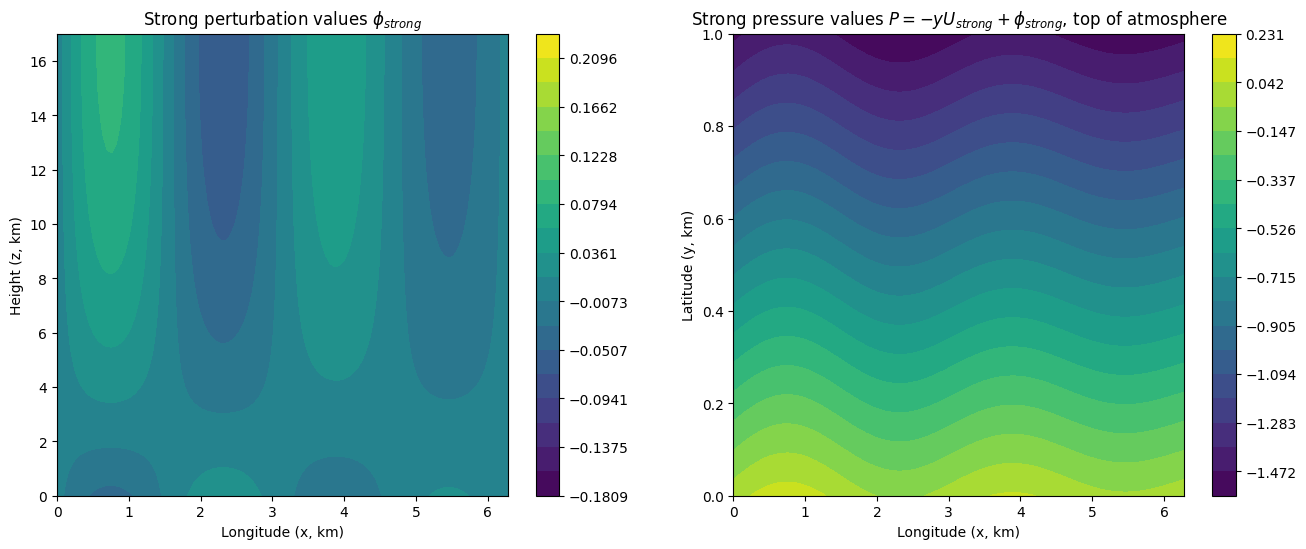

In [168]:
F = lambda x: (np.sin(2*x) / 2)

density_weight = np.exp(-z / (2*H))

U_strong = 1.5
soln_strong = math.nan*np.zeros([nz,nx])

for i in range(0,nx):
    soln_strong[:,i] = solve_withboundary(U_strong, F(x[i]))

strong_discretized_figs()

Now we solve for the pressure $P=-yU_{\text{weak}}+\phi_{\text{weak}}$ with $U_{\text{weak}}=0.5$.

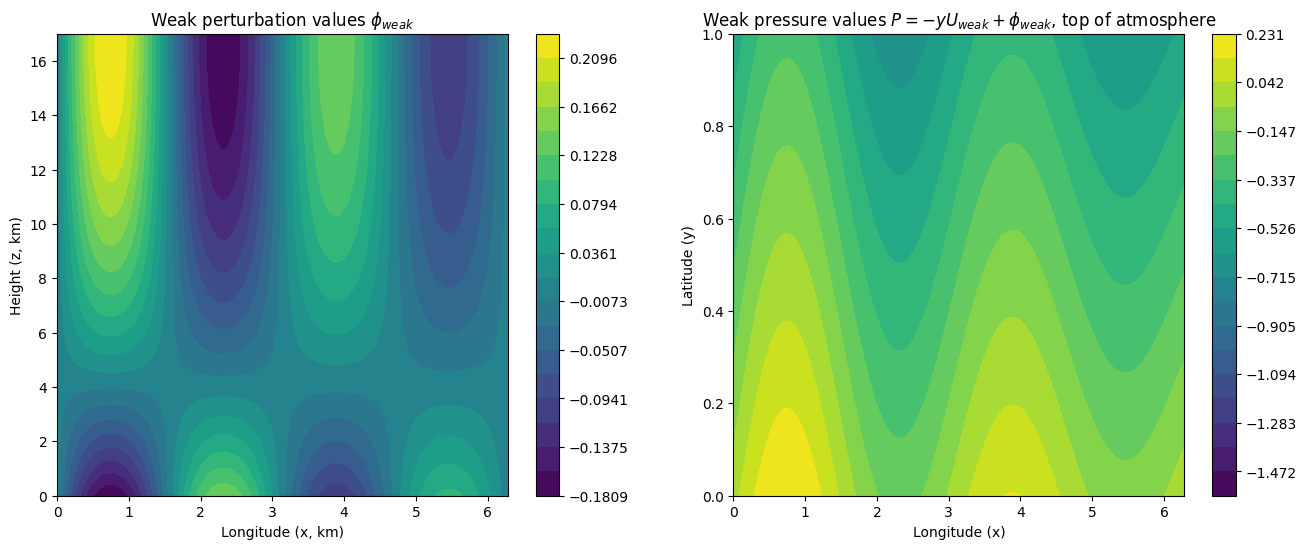

In [169]:
U_weak = 0.5
soln_weak = math.nan*np.zeros([nz,nx])

for i in range(0,nx):
    soln_weak[:,i] = solve_withboundary(U_weak, F(x[i]))

weak_discretized_figs()

## Analytic solution

The authors provide analytic solutions to (7) under the boundary conditions described above. The solutions depend on the sign of the discriminant of the characteristic polynomial. We provide both solutions below.

Let

$$q=\sqrt{\frac{1}{4H^2}-\frac{\beta_LS}{U}}$$

and

$$m = \sqrt{\frac{\beta_LS}{U}-\frac{1}{4H^2}}.$$

Then the analytic solutions are of the form

\begin{align*}
\text{Strong wind:}\quad\phi_L&=\frac{Q_0F(x)}{U(k_s^2+\frac{1}{H}k_s)+\beta_LS}\left(-\frac{e^{\frac{1}{2H}-q}-e^{-k_s}}{2e^{\frac{1}{2H}}\sinh(q)}e^{\left(\frac{1}{2H}+q\right)z}-\frac{e^{\frac{1}{2H}+q}-e^{-k_s}}{2e^{\frac{1}{2H}}\sinh(q)}e^{\left(\frac{1}{2H}-q\right)z}-\left(k_s+\frac{1}{H}\right)e^{-k_sz}\right)\\ \\
&=A_0F(x)\left(B_0f_0(z)-C_0g_0(z)-D_0h_0(z)\right)
\end{align*}

\begin{align*}
\text{Weak wind:}\quad\phi_L&=\frac{Q_0F(x)}{U(k_s^2+\frac{1}{H}k_s)+\beta_LS}e^{\frac{z}{2H}}\left(\frac{\sin(mz-m)-e^{-\left(k_s+\frac{1}{2H}\right)}\sin(mz)}{\sin(m)}\right)+\frac{Q_0F(x)}{U(k_s^2+\frac{1}{H}k_s)+\beta_LS}e^{-k_sz}\\ \\
&=A_0F(x)f_1(z)g_1(z)+A_0F(x)h_1(z)
\end{align*}

We have labeled the functions above for ease of readability in the code. Constants are all marked by capital letters, functions by the addition of a parameter, and each term is presented in the same order as in the equation above it.

In [170]:
def analytic(x, z, U):
    q = np.sqrt( ( 1 / (4*(H**2)) ) - ( (beta*S) / (U) ) )
    m = np.sqrt( ( ((beta*S) / (U)) - ((1) / (4*(H**2))) ) )

    # positive discriminant
    A_0 = Q_0 / (U *( k_s**2 + (1 / H)*k_s ) *beta*S)
    B_0 = (np.exp((1/2*H)-q) - np.exp(-k_s)) / (2*np.exp(1/(2*H))*np.sinh(q))
    C_0 = (np.exp((1/2*H)+q) - np.exp(-k_s)) / (2*np.exp(1/(2*H))*np.sinh(q))
    D_0 = (k_s + (1/H))
    f_0 = np.exp( ( (1/(2*H)) + q )*z )
    g_0 = np.exp( ( (1/(2*H)) - q )*z )
    h_0 = np.exp(-k_s * z)

    phi_Lpos = A_0*F(x)*( B_0*f_0 - C_0*g_0 - D_0*h_0 )

    # negative discriminant
    f_1 = np.exp(z / (2*H))
    g_1 = ( np.sin(m*z - m) - np.exp(k_s+(1/(2*H)))*np.sin(m*z) ) / (np.sin(m))
    h_1 = np.exp(-k_s * z)

    phi_Lneg = A_0*F(x)*f_1*g_1 + A_0*F(x)*h_1

    return phi_Lpos, phi_Lneg

With a function to compute these analytic solutions in hand we now may compute solutions across all values of $x$ and $z$, as well as computing $P=-yU+\phi$ for these analytic solutions:

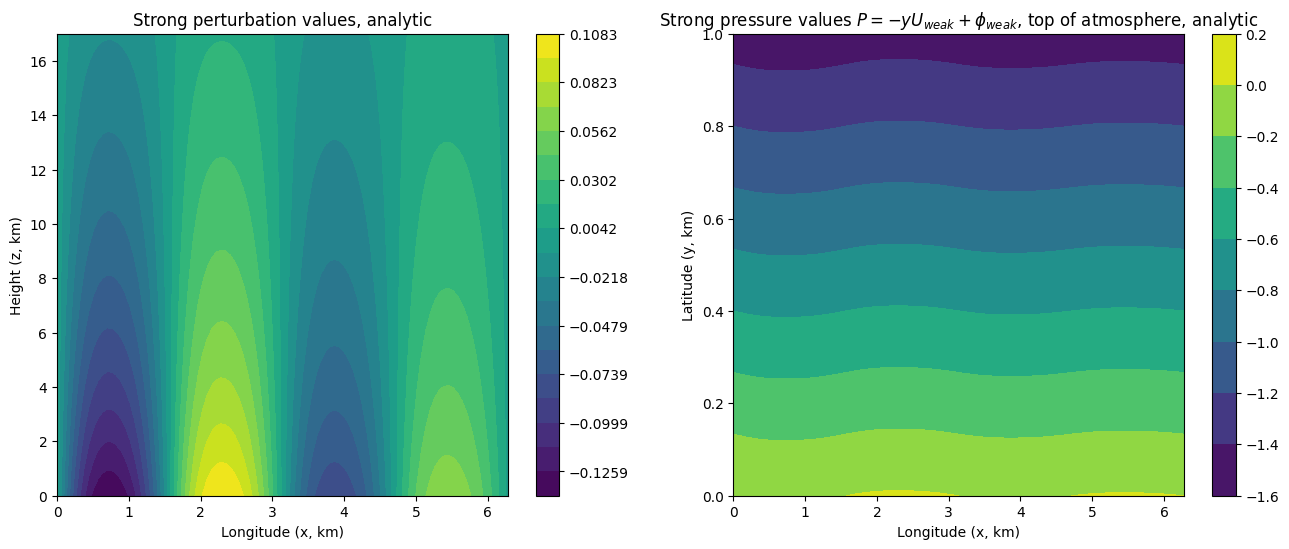

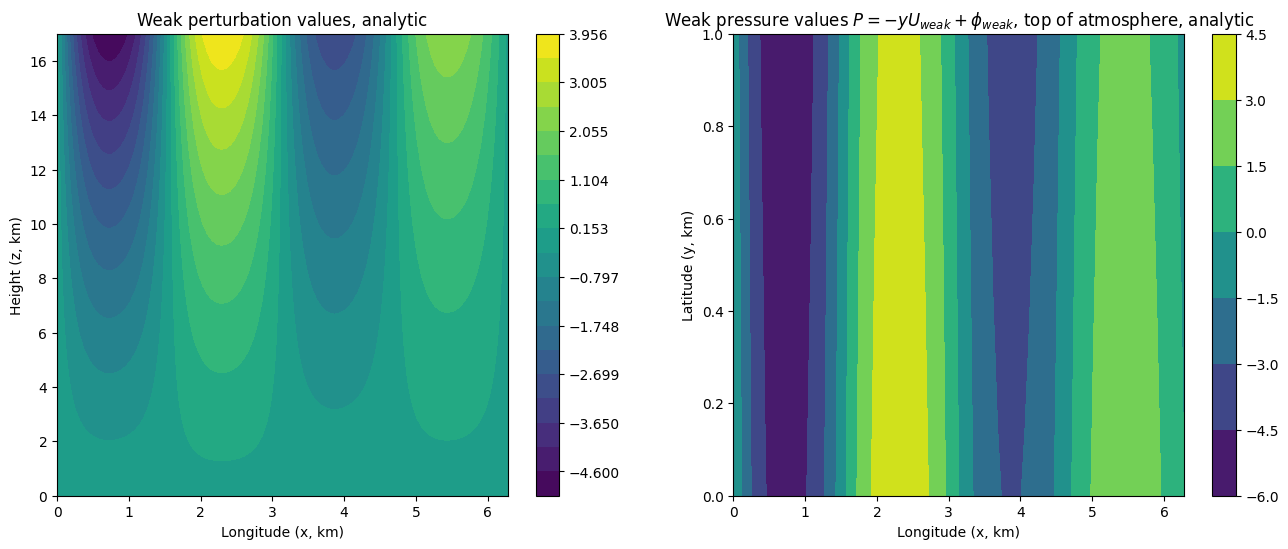

In [171]:
strong_analytic_figs()
weak_analytic_figs()

## Pre-built solver

Here we implement a pre-built solver, blackboxed via the `Py-PDE` package.

In [39]:
import pde

grid = pde.CartesianGrid([[0,x_f], [0,z_T]], [nx, nz])
field = pde.ScalarField(grid, data=[x, z])

eq = 

storage = 

SyntaxError: invalid syntax (1084326718.py, line 6)

# Results

# References
W. Moon, B. Kim, G. Yang, & J.S. Wettlaufer, Wavier jet streams driven by zonally asymmetric surface thermal forcing, Proc. Natl. Acad. Sci. U.S.A. 119 (38) e2200890119, https://doi.org/10.1073/pnas.2200890119 (2022).

# Utility functions to display figures

This section contains code that renders figures earlier in the report. Nothing functional is implemented here.

The code block below computes maxima and minima of our pressure and perturbation functions so that our plots have consistent coloring.

In [152]:
phimax = np.max([np.max(soln_strong*density_weight), np.max(soln_weak*density_weight)])
phimin = np.min([np.min(soln_strong*density_weight), np.min(soln_weak*density_weight)])

y = np.linspace(0, 1, 50)
xgrid, ygrid = np.meshgrid(x,y)
soln_strong_grid, tmp = np.meshgrid((soln_strong*density_weight)[-1,:], y)
soln_weak_grid, tmp = np.meshgrid((soln_weak*density_weight)[-1,:], y)

p_strong = -1.5*ygrid + soln_strong_grid
p_weak = -0.5*ygrid + soln_weak_grid

pmax = np.max([np.max(p_strong), np.max(p_weak)])
pmin = np.min([np.min(p_strong), np.min(p_weak)])

The code block below implements two functions, each of which displays contour plots for the strong or weak numerical solution to the discretized version of equation (7).

In [167]:
def strong_discretized_figs():
    # strong perturbation values
    fig, ax = plt.subplots(1, 2, figsize=[16,6])
    philevels = np.linspace(phimin, phimax, 20)
    phicontourset = ax[0].contourf(x, 17*z, soln_strong*density_weight, levels=philevels)
    plt.colorbar(phicontourset)
    ax[0].set_title("Strong perturbation values $\phi_{\t{strong}}$")
    ax[0].set_xlabel("Longitude (x, km)")
    ax[0].set_ylabel("Height (z, km)")

    # strong pressure values
    plevels = np.linspace(pmin, pmax, 20)
    pcontourset = ax[1].contourf(x, y, p_strong, levels=plevels)
    plt.colorbar(pcontourset)
    ax[1].set_title("Strong pressure values $P=-yU_{\t{strong}}+\phi_{\t{strong}}$, top of atmosphere")
    ax[1].set_xlabel("Longitude (x, km)")
    ax[1].set_ylabel("Latitude (y, km)")

def weak_discretized_figs():
    # weak perturbation values
    fig, ax = plt.subplots(1, 2, figsize=[16,6])
    philevels = np.linspace(phimin, phimax, 20)
    phicontourset = ax[0].contourf(x, 17*z, soln_weak*density_weight, levels=philevels)
    plt.colorbar(phicontourset)
    ax[0].set_title("Weak perturbation values $\phi_{\t{weak}}$")
    ax[0].set_xlabel("Longitude (x, km)")
    ax[0].set_ylabel("Height (z, km)")

    # weak pressure values
    plevels = np.linspace(pmin, pmax, 20)
    pcontourset = ax[1].contourf(x, y, p_weak, levels=plevels)
    plt.colorbar(pcontourset)
    ax[1].set_title("Weak pressure values $P=-yU_{\t{weak}}+\phi_{\t{weak}}$, top of atmosphere")
    ax[1].set_xlabel("Longitude (x)")
    ax[1].set_ylabel("Latitude (y)")

We now turn to rendering our analytic solutions. First we compute the analytic solutions across $x$ and $z$ and find similar minima and maxima.

In [166]:
analytic_soln_strong, tmp = analytic(x,z,1.5)
tmp, analytic_soln_weak = analytic(x,z,0.5)

analytic_soln_strong = math.nan*np.zeros([nz,nx])

for i in range(0,nx):
    analytic_soln_strong[:,i] = analytic(F(x[i]), z, U_strong)[0]

analytic_soln_weak = math.nan*np.zeros([nz,nx])

for i in range(0,nx):
    analytic_soln_weak[:,i] = analytic(F(x[i]), z, U_weak)[1]

a_phimax = np.max([np.max(analytic_soln_strong*density_weight), np.max(analytic_soln_weak*density_weight)])
a_phimin = np.min([np.min(analytic_soln_strong*density_weight), np.min(analytic_soln_weak*density_weight)])

a_strong_grid, tmp = np.meshgrid((analytic_soln_strong*density_weight)[-1,:], y)
a_weak_grid, tmp = np.meshgrid((analytic_soln_weak*density_weight)[-1,:], y)

a_p_strong = -1.5*ygrid + a_strong_grid
a_p_weak = -0.5*ygrid + a_weak_grid

a_pmax = np.max([np.max(a_p_strong), np.max(a_p_weak)])
a_pmin = np.min([np.min(a_p_strong), np.min(a_p_weak)])

/tmp/ipykernel_4542/2995403298.py:3: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt( ( ((beta*S) / (U)) - ((1) / (4*(H**2))) ) )
/tmp/ipykernel_4542/2995403298.py:2: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt( ( 1 / (4*(H**2)) ) - ( (beta*S) / (U) ) )


The code block below implements two functions, each of which displays contour plots for the strong or weak analytic solution to equation (7).

In [165]:
def strong_analytic_figs():
    # strong perturbation values
    fig, ax = plt.subplots(1, 2, figsize=[16,6])
    philevels = np.linspace((analytic_soln_strong*density_weight).min(), (analytic_soln_strong*density_weight).max(), 20)
    a_phicontourset = ax[0].contourf(x, 17*z, analytic_soln_strong*density_weight, levels=philevels)
    plt.colorbar(a_phicontourset)
    ax[0].set_title("Strong perturbation values, analytic")
    ax[0].set_xlabel("Longitude (x, km)")
    ax[0].set_ylabel("Height (z, km)")

    # strong pressure values
    a_plevels = np.linspace((a_p_strong).min(), (a_p_strong).max(), 20)
    a_pcontourset = ax[1].contourf(x, y, a_p_strong)
    plt.colorbar(a_pcontourset)
    ax[1].set_title("Strong pressure values $P=-yU_{\t{weak}}+\phi_{\t{weak}}$, top of atmosphere, analytic")
    ax[1].set_xlabel("Longitude (x, km)")
    ax[1].set_ylabel("Latitude (y, km)")

def weak_analytic_figs():
    # weak perturbation values
    fig, ax = plt.subplots(1, 2, figsize=[16,6])
    philevels = np.linspace((analytic_soln_weak*density_weight).min(), (analytic_soln_weak*density_weight).max(), 20)
    a_phicontourset = ax[0].contourf(x, 17*z, analytic_soln_weak*density_weight, levels=philevels)
    plt.colorbar(a_phicontourset)
    ax[0].set_title("Weak perturbation values, analytic")
    ax[0].set_xlabel("Longitude (x, km)")
    ax[0].set_ylabel("Height (z, km)")

    # weak pressure values
    a_plevels = np.linspace((a_p_weak).min(), (a_p_weak).max(), 20)
    a_pcontourset = ax[1].contourf(x, y, a_p_weak)
    plt.colorbar(a_pcontourset)
    ax[1].set_title("Weak pressure values $P=-yU_{\t{weak}}+\phi_{\t{weak}}$, top of atmosphere, analytic")
    ax[1].set_xlabel("Longitude (x, km)")
    ax[1].set_ylabel("Latitude (y, km)")